In [1]:
import pandas as pd
import numpy as np
from math import log
import Quandl as q
import matplotlib.pyplot as plt

from IPython.html.widgets import interact

from datetime import date 
from datetime import timedelta
import sys

%matplotlib inline

import seaborn as sns
sns.set()

pd.options.mode.chained_assignment = None 

:0: FutureWarning: IPython widgets are experimental and may change in the future.


##S&P 500 Constituents

Quandl.com publishes a static file with current S&P500 constituents that we'll use for current signals

In [2]:
sp_500_url = "https://s3.amazonaws.com/quandl-static-content/Ticker+CSV%27s/Indicies/SP500.csv"
sp_500 = pd.DataFrame.from_csv(sp_500_url);

Quandl does not however have a nice list of index symbols. We'll need those for benchmarking, so let's add those to the main symbol data 

In [3]:
index_etfs = pd.DataFrame.from_csv("index_etfs.csv")

In [4]:
index_etfs["TickerType"] = "Benchmark"
sp_500["TickerType"] = "Constituent"

In [5]:
index_etfs

,TickerType
Ticker,
INDEX_SPY,Benchmark
INDEX_DJI,Benchmark
TSX_QQC_TO,Benchmark
INDEX_RUT,Benchmark


In [6]:
stocks = sp_500.append(index_etfs)

In [7]:
stocks.reset_index(inplace=True)

In [8]:
def symbol(s):
    return s.replace('-','_')

def get_search_string(s):
    return "{0}/{1}".format(DATABASE, symbol(s))

## Get Quandl Price Data for Stocks

#####Quandl set up info

In [9]:
DATABASE = "YAHOO"
QUANDL_AUTHTOKEN ="xkXtzxzRcDyizWAV9r3_"

frequency = "daily"
trading_days = 2*252
days = trading_days/5.0*7
d = date.today() - timedelta(days=days)
start_date = d.strftime('%Y-%m-%d')
start_date

'2013-09-28'

We'll go through the list of stocks and download Quandl data one-by-one

In [10]:
def get_stock_prices():

    global stocks
    stocks.sort("Ticker", inplace=True)

    price_data = None

    for i, stock in stocks.iterrows():

        s = symbol(stock.Ticker)
        ticker_type = stock.TickerType
        search = get_search_string(s)

        try:
            df = q.get(search, authtoken=QUANDL_AUTHTOKEN, 
                           collapse=frequency,
                           sort_order="asc", 
                           trim_start=start_date)

            df['Symbol'] = s
            df['SymbolType'] = ticker_type

            if (price_data is not None):        
                price_data = price_data.append(df, ignore_index=False)
#                 print('appending {0} rows ({1})'.format(s, len(df.index), len(price_data.index)))
            else:
                # first time around?
                price_data = df
#                 print('initializing {0} rows ({1})'.format(s, len(df.index), len(price_data.index)))     

        except Exception as err:
            print s, err
            pass
    
    #Let's rename some columns. Depending on the source, they could have different names.
    price_data.rename(columns={'Adjusted Close': 'AdjustedClose'}, inplace=True)
    price_data.rename(columns={'Adj. Close': 'AdjustedClose'}, inplace=True)

    return price_data


#####We either update prices from Quandl, or optionally use a previously saved file.

In [155]:
use_local = True

if use_local:
    price_data = pd.DataFrame.from_csv('price_data.csv')
else:
    price_data = get_stock_prices()
    price_data.to_csv('price_data.csv')

In [156]:
# end_date = '2015-08-21'
# price_data = price_data[price_data["Date"] <= end_date]
price_data.tail()

,Open,High,Low,Close,Volume,AdjustedClose,Symbol,SymbolType
Date,,,,,,,,
2015-08-27,44.709999,46.150002,44.110001,45.860001,4539300,45.860001,ZTS,Constituent
2015-08-28,46.009998,46.130001,45.060001,45.779999,2695800,45.779999,ZTS,Constituent
2015-08-31,45.740002,45.910000,44.770000,44.869999,2557600,44.869999,ZTS,Constituent
2015-09-01,43.950001,44.889999,43.779999,43.980000,4270300,43.980000,ZTS,Constituent
2015-09-02,44.520000,45.160000,43.900002,45.119999,2601000,45.119999,ZTS,Constituent


Since we appended this dataframe symbol-by-symbol, the initial index for the dataframe is on Date, so not it's not a unique index.
We have to reset this to get a unique ID for each row, which we'll need later.

We could use a multi-index on Symbol and Date, or just a create a unique integer. Let's use the unique ID, so we can access Symbol and Date as regular columns.

We'll also sort it on Date (desc) and Symbol, so that our window functions work correctly later.

In [157]:
price_data.reset_index(inplace=True)
price_data.sort(['Symbol', 'Date'], ascending=[1, 1] , inplace=True)

##Compute Price Metrics

Next, we compute a variety of metrics based on closing prices

####Log of Closing Prices

In [158]:
%%time
price_data['CloseLog'] = np.log(price_data['Close'])
price_data['AdjustedCloseLog'] = np.log(price_data['AdjustedClose'])

CPU times: user 6.19 ms, sys: 1.69 ms, total: 7.89 ms
Wall time: 7.11 ms


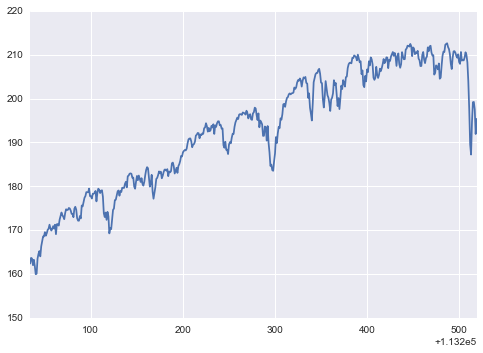

In [159]:
price_data[price_data['Symbol']=='INDEX_SPY']['AdjustedClose'].plot()

####Returns by Stock
We compute 1, 90 and 250 day returns

In [160]:
%%time
price_data['L1DReturn'] = price_data.groupby('Symbol')['AdjustedClose'].diff().fillna(0).replace([np.inf, -np.inf], np.nan)
price_data['L1DReturnPerc'] = price_data.groupby('Symbol')['AdjustedClose'].pct_change().astype(float)
price_data['L1DReturnPerc'] = price_data['L1DReturnPerc'].fillna(0).replace([np.inf, -np.inf], np.nan)

price_data['L90DReturn'] = price_data.groupby('Symbol')['AdjustedClose'].diff(periods=90).fillna(0).replace([np.inf, -np.inf], np.nan)
price_data['L90DReturnPerc'] = price_data.groupby('Symbol')['AdjustedClose'].pct_change(periods=90).astype(float)
price_data['L90DReturnPerc'] = price_data['L90DReturnPerc'].fillna(0).replace([np.inf, -np.inf], np.nan)

price_data['L250DReturn'] = price_data.groupby('Symbol')['AdjustedClose'].diff(periods=250).fillna(0).replace([np.inf, -np.inf], np.nan)
price_data['L250DReturnPerc'] = price_data.groupby('Symbol')['AdjustedClose'].pct_change(periods=250).astype(float)
price_data['L250DReturnPerc'] = price_data['L250DReturnPerc'].fillna(0).replace([np.inf, -np.inf], np.nan)

CPU times: user 1.21 s, sys: 178 ms, total: 1.39 s
Wall time: 1.71 s


We'll annualize the 90 day return values to use later

In [161]:
%%time
price_data['L90DReturnPercAnnual'] = np.power(price_data['L90DReturnPerc']+1, 250)

CPU times: user 8.98 ms, sys: 2.03 ms, total: 11 ms
Wall time: 16.4 ms


####Adjust High and Low prices
Since Yahoo/Google don't only provide adjusted closing prices, we'll have to adjust the daily highs and lows manually by adjusting the high and low by the ratio of the Close and Adjusted Close to account for any splits etc.

In [162]:
%%time
price_data['AdjRatio'] = price_data.Close/price_data.AdjustedClose
price_data['AdjustedHigh'] = price_data.High/price_data.AdjRatio
price_data['AdjustedLow'] = price_data.Low/price_data.AdjRatio

CPU times: user 10.9 ms, sys: 1.5 ms, total: 12.4 ms
Wall time: 13.9 ms


####ATR
Average True Range (ATR) is based on the close, high, low and previous close.

<i>Previous Close</i>

In [163]:
%%time
price_data['AdjustedClosePrevious'] = price_data.groupby('Symbol')['AdjustedClose'].shift(1)

CPU times: user 125 ms, sys: 41.2 ms, total: 167 ms
Wall time: 203 ms


<i>True Range</i>

In [164]:
def true_range(adj_prior_close, adj_close, adj_hi, adj_lo):
    
    adj_hi_lo = adj_hi - adj_lo
    adj_hi_pc = np.abs(adj_hi - adj_prior_close)
    adj_lo_pc = np.abs(adj_lo - adj_prior_close)

    tr = np.max([adj_hi_lo, adj_hi_pc, adj_lo_pc])
    return tr

In [165]:
%%time
price_data['TrueRange'] = price_data.apply(lambda x: true_range(x.AdjustedClosePrevious, 
                                                                x.AdjustedClose, 
                                                                x.AdjustedHigh,
                                                                x.AdjustedLow
                                                               ), axis=1) 

CPU times: user 32 s, sys: 723 ms, total: 32.7 s
Wall time: 35.7 s


<i>Average of the True Range of several timeframes</i>

In [166]:
%%time
price_data['ATR20'] = price_data.groupby('Symbol')['TrueRange'].apply(pd.rolling_mean, window=20, min_periods=20)
price_data['ATR90'] = price_data.groupby('Symbol')['TrueRange'].apply(pd.rolling_mean, window=90, min_periods=90)
price_data['ATR100'] = price_data.groupby('Symbol')['TrueRange'].apply(pd.rolling_mean, window=100, min_periods=100)

CPU times: user 301 ms, sys: 91.5 ms, total: 393 ms
Wall time: 418 ms


##Let's take a quick look at the returns distribution...

In [167]:
std = lambda x: (x - x.mean())/ (x.max() - x.min())
norm = lambda x: (x - x.mean())/ (x.std())

price_data["L90DReturnPercStd"] = price_data.groupby('Symbol')["L90DReturn"].apply(std) 
price_data["L90DReturnPercNorm"] = price_data.groupby('Symbol')["L90DReturn"].apply(norm) 


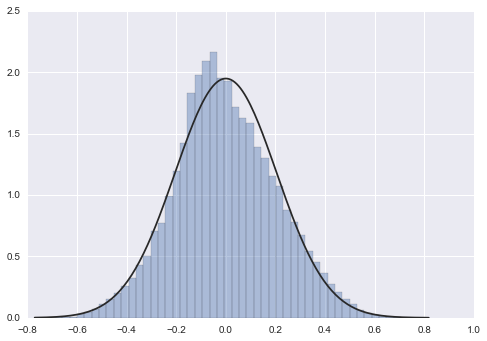

In [168]:
from scipy import stats

plot_data = price_data

x = plot_data['L90DReturnPercStd'].dropna().values.astype(float)

sns.distplot(x, kde=False, fit=stats.norm);

-5.22676224895
6.40769714381


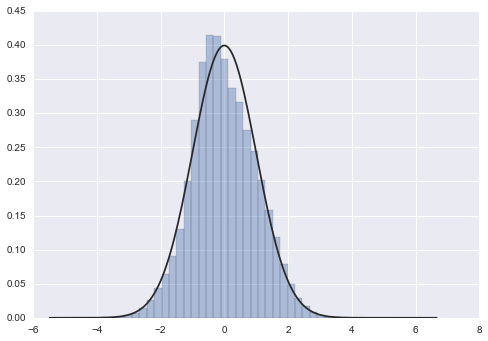

In [169]:
x = plot_data['L90DReturnPercNorm'].dropna().values.astype(float)
print x.min()
print x.max()
sns.distplot(x, kde=False, fit=stats.norm);

As expected, sort of normal.

In [170]:
# x = plot_data[plot_data["Type"]['L90DReturnPercStd'].dropna().values.astype(float)
# sns.axes_style("white")
# sns.jointplot(x=x, y=y, kind="hex", color="k")

In [171]:
plot_data;

## Moving Averages by Stock

In [172]:
%%time
price_data['MA200'] = price_data.groupby('Symbol')['AdjustedClose'].apply(pd.rolling_mean, window=200, min_periods=200)
price_data['MA100'] = price_data.groupby('Symbol')['AdjustedClose'].apply(pd.rolling_mean, window=100, min_periods=100)
price_data['MA50'] = price_data.groupby('Symbol')['AdjustedClose'].apply(pd.rolling_mean, window=50, min_periods=50)
price_data['MA200Diff'] = price_data.AdjustedClose - price_data.MA200 
price_data['MA100Diff'] = price_data.AdjustedClose - price_data.MA100 
price_data['MA50Diff'] = price_data.AdjustedClose - price_data.MA50 

CPU times: user 347 ms, sys: 174 ms, total: 521 ms
Wall time: 559 ms


###Min/Max L1D Return
To be able to catch large gap up or downs, we get the rolling 90 day maximum 1 day return

In [173]:
%%time
price_data['MinL1DReturnPercL90D'] = price_data.groupby('Symbol')['L1DReturnPerc'].apply(
    pd.rolling_min, window=90, min_periods=90)

price_data['MaxL1DReturnPercL90D'] = price_data.groupby('Symbol')['L1DReturnPerc'].apply(
    pd.rolling_max, window=90, min_periods=90)


CPU times: user 342 ms, sys: 192 ms, total: 534 ms
Wall time: 584 ms



##R-Squared

### Let's check out statsmodels OLS

In [174]:
%%time
import numpy as np
import statsmodels.api as sm
# Fit regression model

y = price_data[price_data["Symbol"]=="AAPL"]["AdjustedCloseLog"]
X = price_data[price_data["Symbol"]=="AAPL"].index

results = sm.OLS(y, X).fit()

# Inspect the results
print results.summary()

                            OLS Regression Results                            
Dep. Variable:       AdjustedCloseLog   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 9.359e+04
Date:                Thu, 03 Sep 2015   Prob (F-statistic):               0.00
Time:                        19:14:24   Log-Likelihood:                -148.90
No. Observations:                 486   AIC:                             299.8
Df Residuals:                     485   BIC:                             304.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0037   1.22e-05    305.925      0.0

### Let's use pandas OLS since is has a window paramater

In [175]:
def rolling_lin(x, y, window):

    p = pd.ols(y=y,
               x=x,
               window_type='rolling',
               window=window)
    
    beta = pd.DataFrame(p.beta['x'])
    r2 = pd.DataFrame(p.r2)
    
    df = pd.concat([beta, r2], axis=1)
    
    data = df.reset_index()
    
    data.rename(columns={'level_1': 'index', 'x': 'Slope', 0: 'R2'}, inplace=True)
    data.set_index("index", inplace=True)
    
    return data

We'll create a new grouped series with r-squared values for each symbol. Since we're using a 90 day window, this series won't return the first 90 days for each symbol in the original dataframe.

In [176]:
price_data['row_index'] = price_data.index.astype(np.int64)

In [177]:
%%time
ln = price_data.groupby('Symbol').apply(lambda x: rolling_lin(x.row_index, x.AdjustedCloseLog, 90))

CPU times: user 2min 18s, sys: 2.45 s, total: 2min 20s
Wall time: 2min 49s


We'll create a new dataframe from the series and do some reindexing and renaming 

In [178]:
%%time
df_ln = ln.reset_index()
df_ln.rename(columns={'level_1': 'index', 'x': 'Slope', 0: 'R2'}, inplace=True)
#     df2.reset_index(inplace=True, drop=True)
df_ln.set_index("index", inplace=True)
df_ln.head()

CPU times: user 12 ms, sys: 4.36 ms, total: 16.3 ms
Wall time: 26.1 ms


In [179]:
df_ln;

Last step is to assign the r-squared values to the right rows in the original dataframe

In [180]:
%%time
price_data["R2"] = df_ln.R2
price_data["Slope"] = df_ln.Slope
price_data[price_data["Symbol"] == "NFLX"].tail();

CPU times: user 92.2 ms, sys: 126 ms, total: 218 ms
Wall time: 240 ms


###We'll annualize the slope (beta)
We assume 250 trading days in the year

In [181]:
%%time
trading_days = 250
price_data['SlopeAnnualized'] = ((np.power(np.exp(price_data['Slope']), trading_days)-1)*100)

CPU times: user 13 ms, sys: 2.97 ms, total: 16 ms
Wall time: 21.2 ms


###We 'score' each symbol by adjusting the 90 day annualized return by its 90 day r-squared value

In [182]:
%%time
price_data["SlopeAnnualizedAdj"] = price_data.SlopeAnnualized * price_data.R2

CPU times: user 2.7 ms, sys: 1.01 ms, total: 3.72 ms
Wall time: 4.97 ms



###Let's get the last day of data and run some analytics

In [200]:
last_date = price_data.Date.max()-timedelta(1)
print last_date

2015-09-02 00:00:00


### Add'l Filters

Is the stock trading above its 100 day moving average?

In [201]:
ma_filter = price_data.MA100Diff > 0

Has the stock had any major gaps in last 90 days?

In [202]:
gap_percent = .15
gap_filter = (price_data.MaxL1DReturnPercL90D < gap_percent) & (price_data.MinL1DReturnPercL90D > -gap_percent)

In [203]:
price_data["InFilter"] = ma_filter & gap_filter

###Rank each day by the Adjusted Slope

In [204]:
%%time
price_data["DayRank"] = -1
price_data["DayRank"] = price_data[price_data.InFilter == True] \
    .groupby("Date")['SlopeAnnualizedAdj'].rank(ascending=False)

CPU times: user 151 ms, sys: 32.7 ms, total: 184 ms
Wall time: 186 ms


Get the prior week's rank

In [205]:
%%time
price_data["DayRankPrior"] = price_data.shift(1).DayRank
price_data["DayRankPriorWeek"] = price_data.shift(7).DayRank

CPU times: user 254 ms, sys: 192 ms, total: 445 ms
Wall time: 684 ms


In [206]:
print last_date
date_filter = price_data['Date'] == last_date #'2015-06-19'
date_filter;

2015-09-02 00:00:00


###Get the top stocks that meet the filters

In [207]:
display_cols = ['DayRank', 'DayRankPrior', 'DayRankPriorWeek', 'Date', 'Symbol', 'AdjustedClose', 'AdjustedCloseLog', 
                'L90DReturnPerc', 'MinL1DReturnPercL90D', 'MaxL1DReturnPercL90D', 
                'R2', 'Slope', 'SlopeAnnualized', 'SlopeAnnualizedAdj',
                'ATR20', 'ATR90', 'ATR100']

In [208]:
portfolio = price_data[(price_data.InFilter == True) & date_filter & (price_data['DayRank'] <= 30)]
portfolio.sort("DayRank");

##Position Sizing

<i>Some setup columns</i>

In [209]:
%%time
atr_factor = 2
capital = 100000
max_portfolio_weight = 0.05
position_capital = capital * max_portfolio_weight
portfolio_risk_factor = 0.005
capital_at_risk = (capital * portfolio_risk_factor)

portfolio["ATR90Perc"] =  portfolio["ATR90"]/portfolio["AdjustedClose"]
portfolio["ATRStop"] =  portfolio["ATR90"]*atr_factor
portfolio["ATRStop"] =  portfolio["ATR90"]*atr_factor
portfolio["PositionUnits"] = (capital_at_risk/portfolio["ATRStop"]).astype(int)
portfolio["PositionSize"] = portfolio["AdjustedClose"] * portfolio["PositionUnits"]
portfolio["PositionWeight"] = portfolio["PositionSize"] / capital

portfolio["PositionWeightNorm"] = (portfolio.PositionSize/portfolio.PositionSize.sum())
portfolio["PositionSizeNorm"] = (portfolio.PositionWeightNorm * capital)
portfolio["PositionUnitsNorm"] = (portfolio.PositionSizeNorm / portfolio.AdjustedClose).astype(int)

CPU times: user 3.9 ms, sys: 523 µs, total: 4.42 ms
Wall time: 3.96 ms


In [210]:
portfolio

,Date,Open,High,Low,Close,Volume,AdjustedClose,Symbol,SymbolType,CloseLog,...,DayRankPrior,DayRankPriorWeek,ATR90Perc,ATRStop,PositionUnits,PositionSize,PositionWeight,PositionWeightNorm,PositionSizeNorm,PositionUnitsNorm
12115,2015-09-02,72.720001,73.099998,72.239998,73.089996,359700,73.089996,AIZ,Constituent,4.291692,...,2,1,0.016567,2.421796,206,15056.539176,0.150565,0.037684,3768.449334,51
17914,2015-09-02,505.089996,510.859985,497.720001,510.549988,3689600,510.549988,AMZN,Constituent,6.235489,...,3,2,0.021914,22.376672,22,11232.099736,0.112321,0.028112,2811.243558,5
27639,2015-09-02,189.360001,191.869995,187.660004,191.860001,510300,191.860001,BCR,Constituent,5.256766,...,10,17,0.016404,6.294369,79,15156.940079,0.151569,0.037936,3793.578330,19
36388,2015-09-02,41.299999,41.330002,40.779999,41.099998,4036800,41.099998,CAG,Constituent,3.716008,...,6,3,0.016575,1.362447,366,15042.599268,0.150426,0.037650,3764.960362,91
39792,2015-09-02,51.430000,51.549999,50.959999,51.540001,2141700,51.540001,CCE,Constituent,3.942358,...,21,28,0.018386,1.895218,263,13555.020263,0.135550,0.033926,3392.639336,65
40764,2015-09-02,48.660000,49.439999,48.369999,49.439999,3930300,49.439999,CCL,Constituent,3.900760,...,NaN,NaN,0.019955,1.973147,253,12508.319747,0.125083,0.031307,3130.664269,63
47464,2015-09-02,713.690002,724.000000,710.580017,723.869995,370100,723.869995,CMG,Constituent,6.584612,...,11,22,0.015681,22.701995,22,15925.139890,0.159251,0.039858,3985.848415,5
62382,2015-09-02,29.990000,30.680000,29.549999,30.680000,4413100,30.680000,DHI,Constituent,3.423611,...,7,20,0.023056,1.414716,353,10830.040000,0.108300,0.027106,2710.613411,88
68215,2015-09-02,68.040001,68.959999,67.709999,68.959999,1661900,68.959999,DRI,Constituent,4.233527,...,NaN,NaN,0.019430,2.679723,186,12826.559814,0.128266,0.032103,3210.315479,46
81799,2015-09-02,112.480003,113.389999,110.879997,113.379997,919100,113.379997,EXPE,Constituent,4.730745,...,14,14,0.025984,5.892242,84,9523.919748,0.095239,0.023837,2383.709072,21


In [211]:
cols = ["DayRank", "Symbol", "SlopeAnnualizedAdj", "ATR90", "MinL1DReturnPercL90D", "MaxL1DReturnPercL90D", "PositionWeightNorm", "PositionSizeNorm"]
# portfolio["FinVizLink"] = "<img src='http://finviz.com/chart.ashx?t={0}&ty=c&p=d&s=m&ta=0' />".format(portfolio.Symbol)
portfolio[cols].sort("DayRank")
# portfolio[cols].to_csv('portfolio.csv')


,DayRank,Symbol,SlopeAnnualizedAdj,ATR90,MinL1DReturnPercL90D,MaxL1DReturnPercL90D,PositionWeightNorm,PositionSizeNorm
217653,1,UA,96.285666,2.044777,-0.068495,0.073403,0.029204,2920.363526
17914,2,AMZN,79.359032,11.188336,-0.062896,0.097972,0.028112,2811.243558
12115,3,AIZ,76.955773,1.210898,-0.043554,0.032070,0.037684,3768.449334
62382,4,DHI,56.149767,0.707358,-0.047727,0.043847,0.027106,2710.613411
105454,5,HIG,54.938951,0.856714,-0.048353,0.063026,0.033197,3319.745960
215709,6,TWC,51.546816,3.029458,-0.024075,0.072555,0.038022,3802.183059
47464,7,CMG,50.372301,11.350998,-0.022084,0.078372,0.039858,3985.848415
27639,8,BCR,50.011215,3.147184,-0.037963,0.046252,0.037936,3793.578330
83257,9,FB,50.005497,2.196333,-0.049837,0.050482,0.025423,2542.303183
36388,10,CAG,49.969624,0.681223,-0.034892,0.108640,0.037650,3764.960362


##FinViz Link

In [212]:
stocks = portfolio.Symbol.tolist()
print "http://finviz.com/screener.ashx?v=211&t={0}&ta=0".format(",".join(stocks))

http://finviz.com/screener.ashx?v=211&t=AIZ,AMZN,BCR,CAG,CCE,CCL,CMG,DHI,DRI,EXPE,FB,FISV,HIG,HRL,LEN,LLY,LMT,MDLZ,MHK,NKE,ORLY,PGR,RAI,REGN,SBUX,SEE,TSS,TWC,UA,UHS&ta=0


In [213]:
import statsmodels.api as sm

In [197]:
# df = price_data[price_data['Symbol'] == "AAPL"]

In [198]:
# ticker_text_input = widgets.DropdownWidget()
# ticker_text_input.values  = {s: s for s in price_data.Symbol }
# ticker_text_input.value = 'CCE'
# ticker_text_input.description = 'Select a Ticker'

def draw_plot(Ticker):
    
    lamb = 129600
    lamb_sh = 100
    if Ticker:
        df = price_data[price_data['Symbol'] == Ticker]
        
        if not df.empty:
        
            snp_cycle, snp_trend = sm.tsa.filters.hpfilter(df.AdjustedClose, lamb=lamb)
            snp_cycle_sh, snp_trend_sh = sm.tsa.filters.hpfilter(df.AdjustedClose, lamb=lamb_sh)

            plt.figure(figsize=(12,9))
            plt.plot_date(df.Date, df.AdjustedClose, '-', label="Close")
            plt.plot_date(df.Date, snp_cycle, '-', label="Cycle")
            plt.plot_date(df.Date, snp_trend, '-', label="Trend")
            # plt.plot_date(df.Date, snp_trend_sh, '-', label="Trend")
            plt.plot_date(df.Date, df.MA100, '--', label="MA")
            plt.plot_date(df.Date, df.MA200, '--', label="MA")

symbols = [s for s in price_data.Symbol.unique()]
interact(draw_plot, Ticker="")

<function __main__.draw_plot>

-1.0
10827.7308924
241095    0.114062
241096    0.114062
241097    0.114062
241098    0.114062
241099    0.114062
Name: MaxL1DReturnPercL90D, dtype: float64


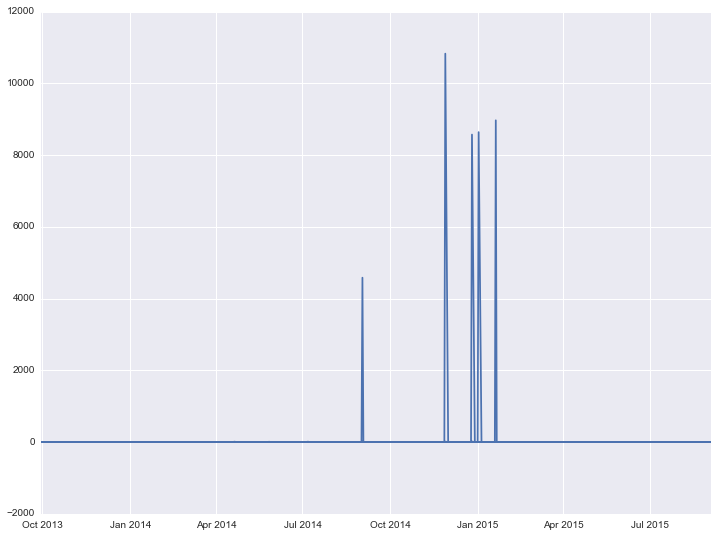

In [199]:
print price_data.L1DReturnPerc.min()
print price_data.L1DReturnPerc.max()
print price_data.MaxL1DReturnPercL90D.tail()

plt.figure(figsize=(12,9))
plt.plot_date(price_data.Date, price_data.L1DReturnPerc, '-', label="%")